<a href="https://colab.research.google.com/github/missmisspa/bda/blob/main/Big_Data_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


<ipython-input-15-f65233460d40>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=combo_pd["Item1"] + " & " + combo_pd["Item2"], x="Frequency", data=combo_pd, palette="rocket")


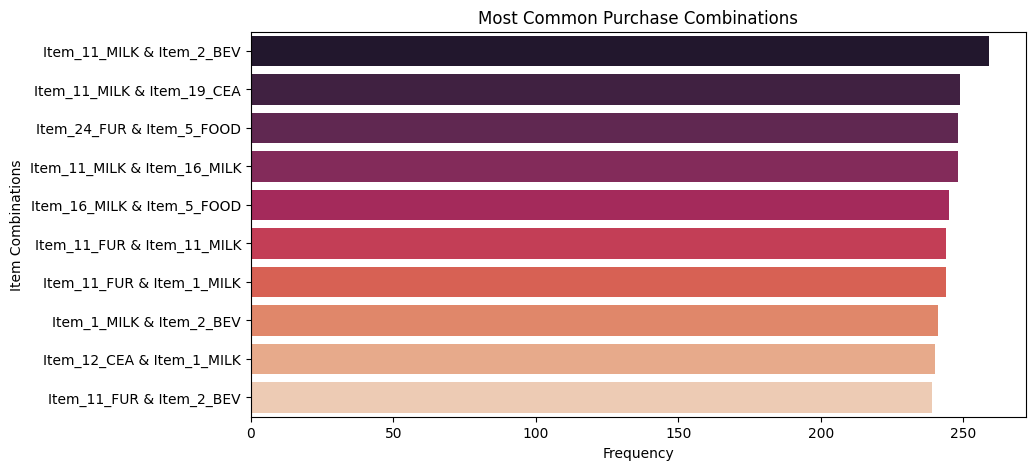

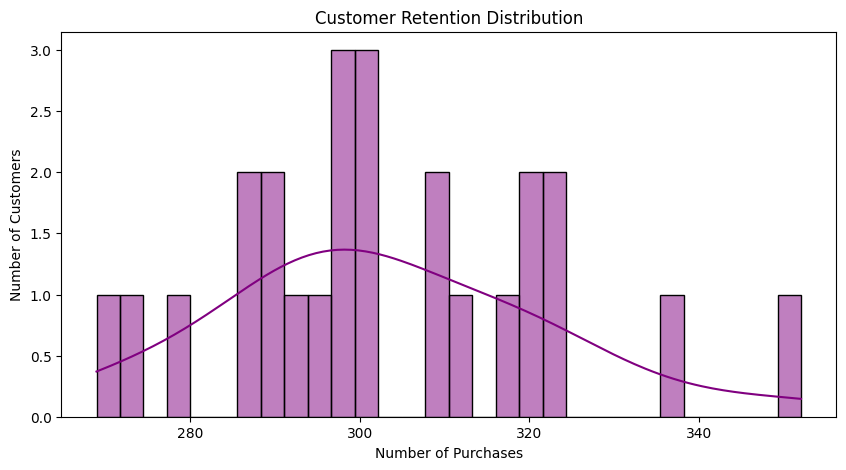

<ipython-input-15-f65233460d40>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DayOfWeek", y="Total Sales", data=day_sales_pd, palette="muted")


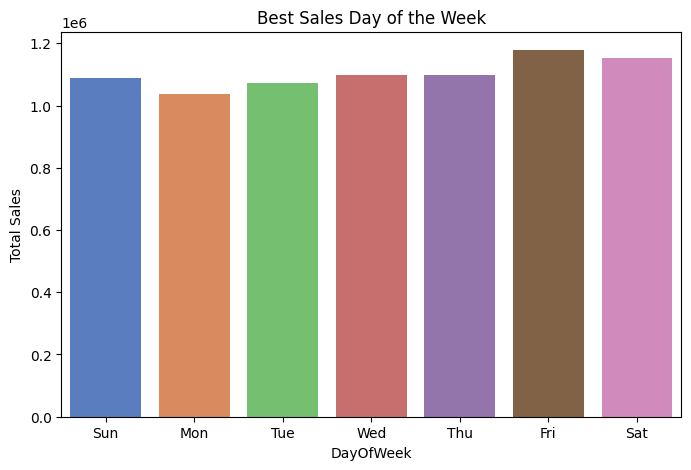

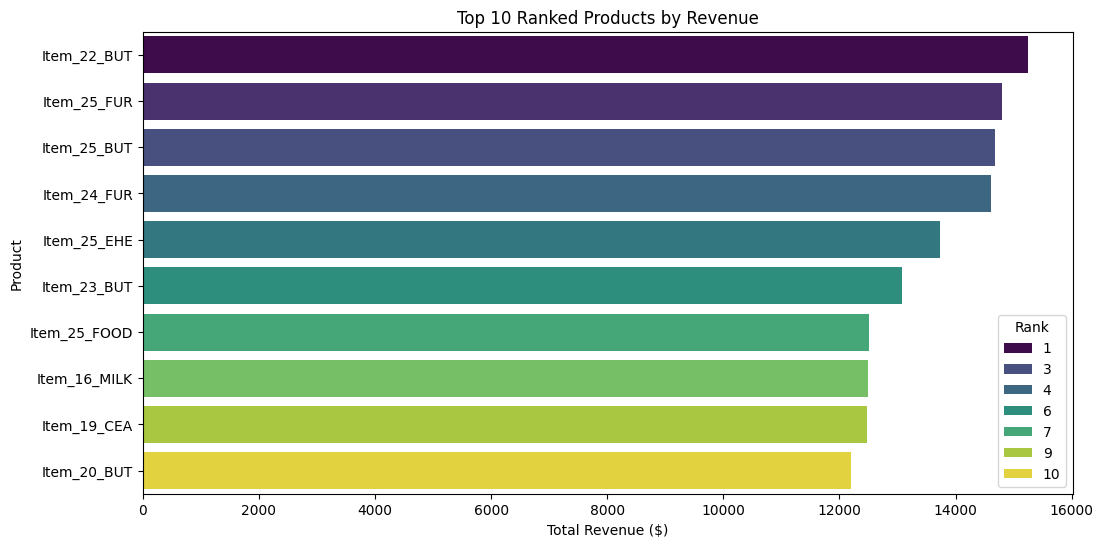

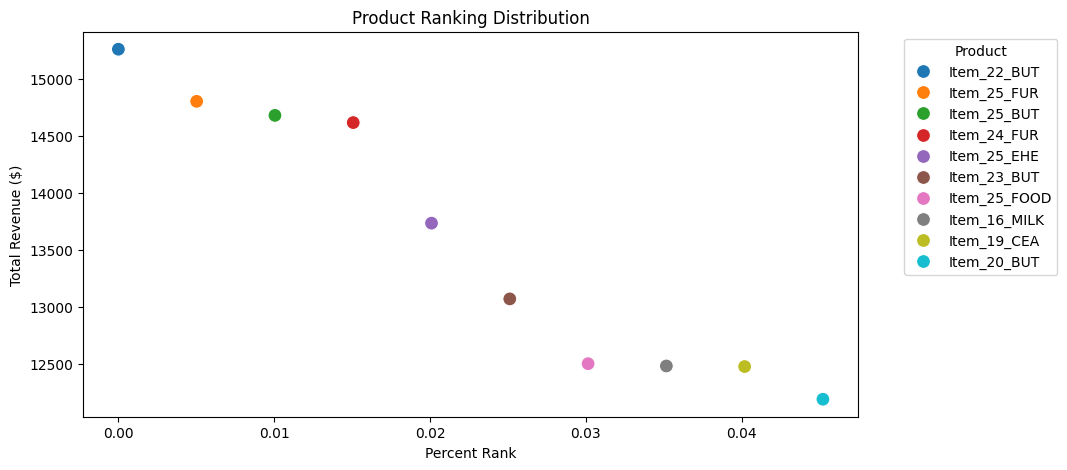

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, avg, rank, dense_rank, percent_rank, row_number, month, year, dayofweek
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

# Install PySpark in Google Colab
!pip install pyspark

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Initialize Spark session
spark = SparkSession.builder.appName("RetailAdvancedAnalysis").getOrCreate()

# Load dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/Final_Final_cleaned_retail_store_sales.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn("Transaction Date", col("Transaction Date").cast("timestamp"))
df.createOrReplaceTempView("sales")

# ================== Spark Operation 1: Find Most Common Purchase Combinations ==================
combo_sql = spark.sql("""
    SELECT A.Item AS Item1, B.Item AS Item2, COUNT(*) AS Frequency
    FROM sales A
    JOIN sales B ON A.`Customer ID` = B.`Customer ID` AND A.Item < B.Item
    GROUP BY A.Item, B.Item
    ORDER BY Frequency DESC
    LIMIT 10
""")
combo_pd = combo_sql.toPandas()

# Visualization 1: Most Common Purchase Combinations (Bar Chart)
plt.figure(figsize=(10, 5))
sns.barplot(y=combo_pd["Item1"] + " & " + combo_pd["Item2"], x="Frequency", data=combo_pd, palette="rocket")
plt.title("Most Common Purchase Combinations")
plt.xlabel("Frequency")
plt.ylabel("Item Combinations")
plt.show()

# ================== Spark Operation 2: Customer Retention Analysis  ==================
customer_purchases_sql = spark.sql("""
    SELECT C.`Customer ID`, COUNT(S.`Transaction ID`) AS `Purchase Count`
    FROM (SELECT DISTINCT `Customer ID` FROM sales) C
    JOIN sales S ON C.`Customer ID` = S.`Customer ID`
    GROUP BY C.`Customer ID`
    ORDER BY `Purchase Count` DESC
""")
customer_purchases_pd = customer_purchases_sql.toPandas()

# Visualization 2: Customer Retention Distribution (Histogram)
plt.figure(figsize=(10, 5))
sns.histplot(customer_purchases_pd["Purchase Count"], bins=30, kde=True, color="purple")
plt.title("Customer Retention Distribution")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.show()

# ================== Spark Operation 3: Best Sales Day of the Week ==================
day_sales_sql = spark.sql("""
    SELECT D.DayOfWeek, SUM(S.`Total Spent`) AS `Total Sales`
    FROM (SELECT `Transaction Date`, DAYOFWEEK(`Transaction Date`) AS DayOfWeek FROM sales) D
    JOIN sales S ON D.`Transaction Date` = S.`Transaction Date`
    GROUP BY D.DayOfWeek
    ORDER BY D.DayOfWeek
""")
day_sales_pd = day_sales_sql.toPandas()

# Visualization 3: Best Sales Day of the Week (Bar Chart)
plt.figure(figsize=(8, 5))
sns.barplot(x="DayOfWeek", y="Total Sales", data=day_sales_pd, palette="muted")
plt.xticks(ticks=range(7), labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.title("Best Sales Day of the Week")
plt.show()

# ================== Spark Operation 4: Ranking Products by Revenue ==================
window_spec = Window.orderBy(col("Total Revenue").desc())

# Aggregate revenue per product
product_sales_df = df.groupBy("Item").agg(sum("Total Spent").alias("Total Revenue"))

# Apply rank and dense rank functions
ranked_df = product_sales_df.withColumn("Rank", rank().over(window_spec)) \
                            .withColumn("Dense_Rank", dense_rank().over(window_spec))

# Convert to Pandas for visualization
ranked_pd = ranked_df.toPandas().sort_values(by="Rank").head(10)

# Visualization 4: Top 10 Ranked Products by Revenue
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Revenue", y="Item", hue="Rank", data=ranked_pd, palette="viridis")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Product")
plt.title("Top 10 Ranked Products by Revenue")
plt.legend(title="Rank", loc="lower right")
plt.show()

# ================== Spark Operation 5: Product Ranking Distribution ==================
window_spec_distribution = Window.orderBy(col("Total Revenue").desc())

ranking_distribution_df = product_sales_df.withColumn("Percent_Rank", percent_rank().over(window_spec_distribution))
ranking_distribution_pd = ranking_distribution_df.toPandas().head(10)

# Visualization 5: Product Ranking Distribution
plt.figure(figsize=(10, 5))
sns.scatterplot(x="Percent_Rank", y="Total Revenue", data=ranking_distribution_pd, hue="Item", palette="tab10", s=100)
plt.xlabel("Percent Rank")
plt.ylabel("Total Revenue ($)")
plt.title("Product Ranking Distribution")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Stop Spark session
spark.stop()

In [ ]:
# 1. Finding Most Common Purchase Combinations
# - Identifies which items are frequently bought together.
# - Helps with product bundling and recommendations.

# 2. Customer Retention Analysis
# - Counts how many times each customer makes a purchase.
# - Useful for understanding loyalty and repeat customers.

# 3. Best Sales Day of the Week
# - Determines which day has the highest total sales.
# - Helps in optimizing staffing, promotions, and inventory.

# 4. Ranking Products by Revenue
# - Lists products based on total revenue generated.
# - Helps prioritize stock and pricing strategies.

# 5. Product Ranking Distribution
# - Shows how revenue is distributed across products.
# - Identifies whether a few products drive most sales (80/20 rule).